In [ ]:
print("data = 42")

data = 42


NameError: name 'data_dir' is not defined

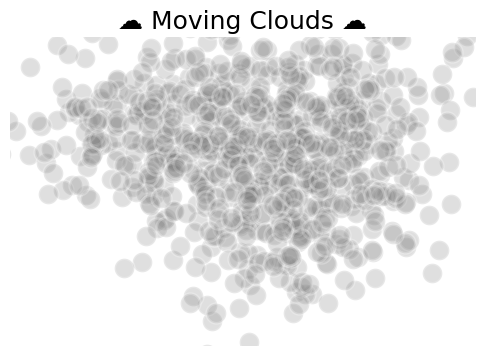

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(6, 4))
scatters = [ax.scatter(c[:, 0], c[:, 1], s=200, alpha=0.25, color='gray', edgecolors='white', linewidth=2) for c in clouds]
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title("☁️ Moving Clouds ☁️", fontsize=18)

def update(frame):
    for idx, c in enumerate(clouds):
        # Move each cloud in a random but smooth direction
        dx = 0.002 * np.sin(1 * frame + idx)
        dy = 0.001 * np.cos(13 * frame + idx)
        c[:, 0] = (c[:, 0] + dx) % 1
        c[:, 1] = (c[:, 1] + dy) % 1
        scatters[idx].set_offsets(c)
    return scatters

ani = FuncAnimation(fig, update, frames=100, interval=50, blit=False)
plt.show()

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Define paths to your dataset
data_dir = "/kaggle/input/zendo-fed-bca/FedBCa/Center1/"  # Adjust this path to your dataset
t2wi_dir = os.path.join(data_dir, "T2WI")
annotation_dir = os.path.join(data_dir, "Annotation")

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Get all T2WI subfolders and pair with annotations
image_mask_pairs = []
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith(".nii")]
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    for t2wi_file in t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_file)
        t2wi_id = t2wi_subfolder.split(".")[0]  # e.g., "001"
        matching_annotation = None
        for ann_file in annotation_files:
            if t2wi_id in ann_file:  # Adjust pairing logic as needed
                matching_annotation = ann_file
                break
        if matching_annotation:
            annotation_path = os.path.join(annotation_dir, matching_annotation)
            image_mask_pairs.append((t2wi_path, annotation_path))
        else:
            print(f"No matching annotation found for T2WI subfolder {t2wi_subfolder}")

# Load images and masks, and find representative slices
images, masks, identifiers, slice_indices = [], [], [], []
for t2wi_path, annotation_path in image_mask_pairs:
    try:
        img = load_nifti(t2wi_path)
        mask = load_nifti(annotation_path)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        mask = (mask > 0).astype(np.uint8)
        tumor_slices = [i for i in range(mask.shape[2]) if mask[:, :, i].sum() > 0]
        slice_idx = tumor_slices[len(tumor_slices) // 2] if tumor_slices else img.shape[2] // 2
        images.append(img)
        masks.append(mask)
        identifiers.append(os.path.basename(t2wi_path))
        slice_indices.append(slice_idx)
    except Exception as e:
        print(f"Error loading {t2wi_path} or {annotation_path}: {e}")

# Visualize all images in a single grid
num_pairs = len(images)
cols = 2  # Two columns per pair (T2WI and T2WI+mask)
rows = num_pairs  # One row per image-mask pair
plt.figure(figsize=(12, 5 * rows))
for i in range(num_pairs):
    # Plot T2WI slice
    plt.subplot(rows, cols, 2 * i + 1)
    plt.imshow(images[i][:, :, slice_indices[i]], cmap="gray")
    plt.title(f"T2WI {identifiers[i]} - Slice {slice_indices[i]}")
    plt.axis("off")
    
    # Plot T2WI slice with mask overlaid
    plt.subplot(rows, cols, 2 * i + 2)
    plt.imshow(images[i][:, :, slice_indices[i]], cmap="gray")
    plt.imshow(masks[i][:, :, slice_indices[i]], cmap="jet", alpha=0.5)
    plt.title(f"T2WI {identifiers[i]} - Slice {slice_indices[i]} with Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [9]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os

# Define paths to your dataset
data_dir = "/kaggle/input/zendo-fed-bca/FedBCa/Center1/"  # Adjust this path
t2wi_dir = os.path.join(data_dir, "T2WI")
annotation_dir = os.path.join(data_dir, "Annotation")

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their annotations
image_mask_pairs = []
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith(".nii")]
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    for t2wi_file in t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_file)
        t2wi_id = t2wi_subfolder.split(".")[0]
        matching_annotation = None
        for ann_file in annotation_files:
            if t2wi_id in ann_file:
                matching_annotation = ann_file
                break
        if matching_annotation:
            annotation_path = os.path.join(annotation_dir, matching_annotation)
            image_mask_pairs.append((t2wi_path, annotation_path))

# print(image_mask_pairs)
# Custom Dataset class
class BladderTumorDataset(Dataset):
    def __init__(self, image_mask_pairs):
        self.image_mask_pairs = image_mask_pairs
        self.slices = []
        # Load images and masks, and collect slices with tumors
        for idx, (img_path, mask_path) in enumerate(self.image_mask_pairs):
            img = load_nifti(img_path)
            mask = load_nifti(mask_path)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            mask = (mask > 0).astype(np.uint8)
            # Store slices with tumors
            for z in range(mask.shape[2]):
                if mask[:, :, z].sum() > 0:
                    self.slices.append((idx, z, img, mask))

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, mask = self.slices[idx]
        img_slice = img[:, :, z]
        mask_slice = mask[:, :, z]
        img_slice = torch.FloatTensor(img_slice).unsqueeze(0)  # Shape: [1, H, W]
        mask_slice = torch.LongTensor(mask_slice)  # Shape: [H, W]
        return img_slice, mask_slice

# Create dataset and dataloader
dataset = BladderTumorDataset(image_mask_pairs)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
dataloader

In [ ]:
# !pip install segmentation-models-pytorch


In [10]:
import segmentation_models_pytorch as smp

# Define the U-Net model
model = smp.Unet(
    encoder_name="resnet34",  # Pretrained backbone
    encoder_weights="imagenet",
    in_channels=1,  # Grayscale images
    classes=2,  # Background (0) and tumor (1)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
import torch.optim as optim

# Loss function and optimizer
criterion = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images_batch, masks_batch in dataloader:
        images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
        
        # Forward pass
        outputs = model(images_batch)
        loss = criterion(outputs, masks_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

RuntimeError: stack expects each tensor to be equal size, but got [1, 320, 320] at entry 0 and [1, 512, 512] at entry 4

In [15]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms

# Define paths to your dataset
data_dir = "/kaggle/input/zendo-fed-bca/FedBCa/Center1/"  # Adjust this path to your dataset

t2wi_dir = os.path.join(data_dir, "T2WI")
annotation_dir = os.path.join(data_dir, "Annotation")

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their annotations
image_mask_pairs = []
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith(".nii")]
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    for t2wi_file in t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_file)
        t2wi_id = t2wi_subfolder.split(".")[0]
        matching_annotation = None
        for ann_file in annotation_files:
            if t2wi_id in ann_file:
                matching_annotation = ann_file
                break
        if matching_annotation:
            annotation_path = os.path.join(annotation_dir, matching_annotation)
            image_mask_pairs.append((t2wi_path, annotation_path))

# Define a resize transform
resize = transforms.Resize((256, 256))  # Resize to 256x256

# Custom Dataset class with resizing
class BladderTumorDataset(Dataset):
    def __init__(self, image_mask_pairs):
        self.image_mask_pairs = image_mask_pairs
        self.slices = []
        # Load images and masks, and collect slices with tumors
        for idx, (img_path, mask_path) in enumerate(self.image_mask_pairs):
            img = load_nifti(img_path)
            mask = load_nifti(mask_path)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            mask = (mask > 0).astype(np.uint8)
            for z in range(mask.shape[2]):
                if mask[:, :, z].sum() > 0:
                    self.slices.append((idx, z, img, mask))

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, mask = self.slices[idx]
        img_slice = img[:, :, z]
        mask_slice = mask[:, :, z]
        # Convert to PyTorch tensors
        img_slice = torch.FloatTensor(img_slice).unsqueeze(0)  # Shape: [1, H, W]
        mask_slice = torch.LongTensor(mask_slice)  # Shape: [H, W]
        # Resize both image and mask
        img_slice = resize(img_slice)  # Shape: [1, 256, 256]
        mask_slice = resize(mask_slice.unsqueeze(0)).squeeze(0)  # Shape: [256, 256]
        return img_slice, mask_slice

# Create dataset and dataloader
dataset = BladderTumorDataset(image_mask_pairs)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Continue with model setup and training
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import torch.optim as optim

# Define the U-Net model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images_batch, masks_batch in dataloader:
        images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
        outputs = model(images_batch)
        loss = criterion(outputs, masks_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

Epoch 1/10, Loss: 0.32545459824939105
Epoch 2/10, Loss: 0.17939044223275297
Epoch 3/10, Loss: 0.14865732192993164
Epoch 4/10, Loss: 0.15023345136365227
Epoch 5/10, Loss: 0.1377750305935394
Epoch 6/10, Loss: 0.10634536902571834
Epoch 7/10, Loss: 0.10142126575458882
Epoch 8/10, Loss: 0.10133365836254386
Epoch 9/10, Loss: 0.09420810327973476
Epoch 10/10, Loss: 0.09267539097819218


In [17]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split

# Define paths to your dataset
data_dir = "/kaggle/input/zendo-fed-bca/FedBCa/Center1/"  # Adjust this path to your dataset
t2wi_dir = os.path.join(data_dir, "T2WI")
annotation_dir = os.path.join(data_dir, "Annotation")

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their annotations
image_mask_pairs = []
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith(".nii")]
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    for t2wi_file in t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_file)
        t2wi_id = t2wi_subfolder.split(".")[0]
        matching_annotation = None
        for ann_file in annotation_files:
            if t2wi_id in ann_file:
                matching_annotation = ann_file
                break
        if matching_annotation:
            annotation_path = os.path.join(annotation_dir, matching_annotation)
            image_mask_pairs.append((t2wi_path, annotation_path))

# Define resize transform
resize = transforms.Resize((256, 256))

# Custom Dataset class
class BladderTumorDataset(Dataset):
    def __init__(self, image_mask_pairs):
        self.image_mask_pairs = image_mask_pairs
        self.slices = []
        for idx, (img_path, mask_path) in enumerate(self.image_mask_pairs):
            img = load_nifti(img_path)
            mask = load_nifti(mask_path)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            mask = (mask > 0).astype(np.uint8)
            for z in range(mask.shape[2]):
                if mask[:, :, z].sum() > 0:
                    self.slices.append((idx, z, img, mask))

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, mask = self.slices[idx]
        img_slice = img[:, :, z]
        mask_slice = mask[:, :, z]
        img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
        mask_slice = torch.LongTensor(mask_slice)
        img_slice = resize(img_slice)
        mask_slice = resize(mask_slice.unsqueeze(0)).squeeze(0)
        return img_slice, mask_slice

# Create dataset
dataset = BladderTumorDataset(image_mask_pairs)

# Split indices into train and validation
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create data loaders for training and validation
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=8, sampler=val_sampler)

In [19]:
# Install segmentation-models-pytorch if not already installed
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import torch.optim as optim

# Define the U-Net model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to compute Dice Score
def dice_score(pred, target, smooth=1):
    pred = torch.argmax(pred, dim=1)  # Convert logits to class predictions
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Training loop with validation
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for images_batch, masks_batch in train_loader:
        images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
        outputs = model(images_batch)
        loss = criterion(outputs, masks_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images_batch, masks_batch in val_loader:
            images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
            outputs = model(images_batch)
            loss = criterion(outputs, masks_batch)
            val_loss += loss.item()
            dice = dice_score(outputs, masks_batch)
            val_dice += dice.item()
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

Epoch 1/10, Train Loss: 0.3564, Val Loss: 0.2732, Val Dice: 0.4948
Epoch 2/10, Train Loss: 0.2208, Val Loss: 0.1828, Val Dice: 0.6472
Epoch 3/10, Train Loss: 0.1689, Val Loss: 0.3729, Val Dice: 0.2810
Epoch 4/10, Train Loss: 0.1549, Val Loss: 0.2410, Val Dice: 0.5259
Epoch 5/10, Train Loss: 0.1509, Val Loss: 0.1469, Val Dice: 0.7117
Epoch 6/10, Train Loss: 0.1365, Val Loss: 0.1595, Val Dice: 0.6862
Epoch 7/10, Train Loss: 0.1381, Val Loss: 0.1486, Val Dice: 0.7085
Epoch 8/10, Train Loss: 0.1070, Val Loss: 0.1091, Val Dice: 0.7852
Epoch 9/10, Train Loss: 0.1150, Val Loss: 0.1054, Val Dice: 0.7928
Epoch 10/10, Train Loss: 0.1010, Val Loss: 0.1418, Val Dice: 0.7199


********************************

In [22]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split

# Define paths to your dataset
data_dir = "/kaggle/input/zendo-fed-bca/FedBCa/Center1/"  # Adjust this path to your dataset
t2wi_dir = os.path.join(data_dir, "T2WI")
annotation_dir = os.path.join(data_dir, "Annotation")

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their annotations
image_mask_pairs = []
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith(".nii")]
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    for t2wi_file in t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_file)
        t2wi_id = t2wi_subfolder.split(".")[0]
        matching_annotation = None
        for ann_file in annotation_files:
            if t2wi_id in ann_file:
                matching_annotation = ann_file
                break
        if matching_annotation:
            annotation_path = os.path.join(annotation_dir, matching_annotation)
            image_mask_pairs.append((t2wi_path, annotation_path))

# Define resize transform
resize = transforms.Resize((256, 256))

# Custom Dataset class
class BladderTumorDataset(Dataset):
    def __init__(self, image_mask_pairs):
        self.image_mask_pairs = image_mask_pairs
        self.slices = []
        # Store slices with their pair index
        for idx, (img_path, mask_path) in enumerate(self.image_mask_pairs):
            img = load_nifti(img_path)
            mask = load_nifti(mask_path)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            mask = (mask > 0).astype(np.uint8)
            for z in range(mask.shape[2]):
                if mask[:, :, z].sum() > 0:
                    self.slices.append((idx, z, img, mask))

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, mask = self.slices[idx]
        img_slice = img[:, :, z]
        mask_slice = mask[:, :, z]
        img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
        mask_slice = torch.LongTensor(mask_slice)
        img_slice = resize(img_slice)
        mask_slice = resize(mask_slice.unsqueeze(0)).squeeze(0)
        return img_slice, mask_slice

    def get_pair_index(self, idx):
        return self.slices[idx][0]  # Return the pair index for this slice

# Create dataset
dataset = BladderTumorDataset(image_mask_pairs)

# Split at the pair level
pair_indices = list(range(len(image_mask_pairs)))  # Indices of T2WI-annotation pairs
train_pair_indices, val_pair_indices = train_test_split(pair_indices, test_size=0.2, random_state=42)

# Map pair indices to slice indices
train_indices, val_indices = [], []
for slice_idx in range(len(dataset)):
    pair_idx = dataset.get_pair_index(slice_idx)
    if pair_idx in train_pair_indices:
        train_indices.append(slice_idx)
    elif pair_idx in val_pair_indices:
        val_indices.append(slice_idx)

# Create data loaders for training and validation
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=8, sampler=val_sampler)

# Model setup and training with validation
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import torch.optim as optim

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=0.001)

def dice_score(pred, target, smooth=1):
    pred = torch.argmax(pred, dim=1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images_batch, masks_batch in train_loader:
        images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
        outputs = model(images_batch)
        loss = criterion(outputs, masks_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images_batch, masks_batch in val_loader:
            images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
            outputs = model(images_batch)
            loss = criterion(outputs, masks_batch)
            val_loss += loss.item()
            dice = dice_score(outputs, masks_batch)
            val_dice += dice.item()
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

Epoch 1/10, Train Loss: 0.3258, Val Loss: 0.4395, Val Dice: 0.1491
Epoch 2/10, Train Loss: 0.1723, Val Loss: 0.3010, Val Dice: 0.4112
Epoch 3/10, Train Loss: 0.1351, Val Loss: 0.2357, Val Dice: 0.5357
Epoch 4/10, Train Loss: 0.1436, Val Loss: 0.2210, Val Dice: 0.5648
Epoch 5/10, Train Loss: 0.1336, Val Loss: 0.2417, Val Dice: 0.5249
Epoch 6/10, Train Loss: 0.1186, Val Loss: 0.1897, Val Dice: 0.6262
Epoch 7/10, Train Loss: 0.1135, Val Loss: 0.1838, Val Dice: 0.6359
Epoch 8/10, Train Loss: 0.0997, Val Loss: 0.1846, Val Dice: 0.6343
Epoch 9/10, Train Loss: 0.0934, Val Loss: 0.2089, Val Dice: 0.5866
Epoch 10/10, Train Loss: 0.1035, Val Loss: 0.1938, Val Dice: 0.6155


In [34]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define paths to your dataset
data_dir = "/kaggle/input/zendo-fed-bca/FedBCa/Center1/"  # Adjust this path to your dataset
t2wi_dir = os.path.join(data_dir, "T2WI")
annotation_dir = os.path.join(data_dir, "Annotation")

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their annotations
image_mask_pairs = []
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith(".nii")]
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    for t2wi_file in t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_file)
        t2wi_id = t2wi_subfolder.split(".")[0]
        matching_annotation = None
        for ann_file in annotation_files:
            if t2wi_id in ann_file:
                matching_annotation = ann_file
                break
        if matching_annotation:
            annotation_path = os.path.join(annotation_dir, matching_annotation)
            image_mask_pairs.append((t2wi_path, annotation_path))

# Define resize transform
resize = transforms.Resize((256, 256))

# Custom Dataset class
class BladderTumorDataset(Dataset):
    def __init__(self, image_mask_pairs):
        self.image_mask_pairs = image_mask_pairs
        self.slices = []
        for idx, (img_path, mask_path) in enumerate(self.image_mask_pairs):
            img = load_nifti(img_path)
            mask = load_nifti(mask_path)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            mask = (mask > 0).astype(np.uint8)
            for z in range(mask.shape[2]):
                if mask[:, :, z].sum() > 0:
                    self.slices.append((idx, z, img, mask))

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, mask = self.slices[idx]
        img_slice = img[:, :, z]
        mask_slice = mask[:, :, z]
        img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
        mask_slice = torch.LongTensor(mask_slice)
        img_slice = resize(img_slice)
        mask_slice = resize(mask_slice.unsqueeze(0)).squeeze(0)
        return img_slice, mask_slice

    def get_pair_index(self, idx):
        return self.slices[idx][0]

# Create dataset
dataset = BladderTumorDataset(image_mask_pairs)

# Split at the pair level
pair_indices = list(range(len(image_mask_pairs)))
train_pair_indices, val_pair_indices = train_test_split(pair_indices, test_size=0.2, random_state=42)
train_indices, val_indices = [], []
for slice_idx in range(len(dataset)):
    pair_idx = dataset.get_pair_index(slice_idx)
    if pair_idx in train_pair_indices:
        train_indices.append(slice_idx)
    elif pair_idx in val_pair_indices:
        val_indices.append(slice_idx)

# Create data loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=8, sampler=val_sampler)

# Model setup and training
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import torch.optim as optim

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=0.001)

def dice_score(pred, target, smooth=1):
    pred = torch.argmax(pred, dim=1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Training loop with validation
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images_batch, masks_batch in train_loader:
        images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
        outputs = model(images_batch)
        loss = criterion(outputs, masks_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images_batch, masks_batch in val_loader:
            images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
            outputs = model(images_batch)
            loss = criterion(outputs, masks_batch)
            val_loss += loss.item()
            dice = dice_score(outputs, masks_batch)
            val_dice += dice.item()
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

# Visualize predictions on validation set
model.eval()
val_iter = iter(val_loader)
images, masks = next(val_iter)  # Get one batch from validation set
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1)  # Convert logits to class predictions

# Move to CPU for visualization
images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
# Visualize the first 4 samples in the batch
num_samples = min(18, len(images))
plt.figure(figsize=(15, 4 * num_samples))
for i in range(num_samples):
    # T2WI image
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title("T2WI Image")
    plt.axis("off")
    
    # Ground truth mask
    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(images[i, 0], cmap="gray")
    plt.imshow(masks[i], cmap="jet", alpha=0.5)
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Predicted mask
    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(images[i, 0], cmap="gray")
    plt.imshow(preds[i], cmap="jet", alpha=0.5)
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

Epoch 1/100, Train Loss: 0.4373, Val Loss: 0.4865, Val Dice: 0.0410
Epoch 2/100, Train Loss: 0.1928, Val Loss: 0.2497, Val Dice: 0.5205
Epoch 3/100, Train Loss: 0.1477, Val Loss: 0.2500, Val Dice: 0.5095
Epoch 4/100, Train Loss: 0.1371, Val Loss: 0.3061, Val Dice: 0.3957
Epoch 5/100, Train Loss: 0.1180, Val Loss: 0.2129, Val Dice: 0.5792
Epoch 6/100, Train Loss: 0.1450, Val Loss: 0.2336, Val Dice: 0.5386
Epoch 7/100, Train Loss: 0.1098, Val Loss: 0.2066, Val Dice: 0.5901
Epoch 8/100, Train Loss: 0.1066, Val Loss: 0.2011, Val Dice: 0.6030
Epoch 9/100, Train Loss: 0.1039, Val Loss: 0.1735, Val Dice: 0.6573
Epoch 10/100, Train Loss: 0.0877, Val Loss: 0.1701, Val Dice: 0.6632
Epoch 11/100, Train Loss: 0.0930, Val Loss: 0.2048, Val Dice: 0.5941
Epoch 12/100, Train Loss: 0.1186, Val Loss: 0.1949, Val Dice: 0.6131
Epoch 13/100, Train Loss: 0.0985, Val Loss: 0.2030, Val Dice: 0.5943
Epoch 14/100, Train Loss: 0.0863, Val Loss: 0.1774, Val Dice: 0.6479
Epoch 15/100, Train Loss: 0.0835, Val Loss:

Paired T2WI-Annotation files: 11
T2WI: /kaggle/input/all-zendo-dataset/DATA/T2WI/c2_42.nii/XIEDIZUO.nii, Annotation: /kaggle/input/all-zendo-dataset/DATA/Annotation/c2_42.nii/XIEDIZUO_Merge_1.nii
T2WI: /kaggle/input/all-zendo-dataset/DATA/T2WI/c2_45.nii/ZHANGMINGXUAN.nii, Annotation: /kaggle/input/all-zendo-dataset/DATA/Annotation/c2_45.nii/ZHANGMINGXUAN_Merge_1.nii
T2WI: /kaggle/input/all-zendo-dataset/DATA/T2WI/c2_36.nii/PENGJIANBO.nii, Annotation: /kaggle/input/all-zendo-dataset/DATA/Annotation/c2_36.nii/PENGJIANBO_Merge_1.nii
T2WI: /kaggle/input/all-zendo-dataset/DATA/T2WI/c2_32.nii/LIJIAYOU.nii, Annotation: /kaggle/input/all-zendo-dataset/DATA/Annotation/c2_32.nii/LIJIAYOU_Merge_1.nii
T2WI: /kaggle/input/all-zendo-dataset/DATA/T2WI/c2_38.nii/SUNCHUANKAI.nii, Annotation: /kaggle/input/all-zendo-dataset/DATA/Annotation/c2_38.nii/SUNCHUANKAI_Merge_1.nii
Epoch 1/50, Train Loss: 0.5833, Val Loss: 0.4998, Val Dice: 0.0014
Epoch 2/50, Train Loss: 0.4892, Val Loss: 0.5198, Val Dice: 0.050

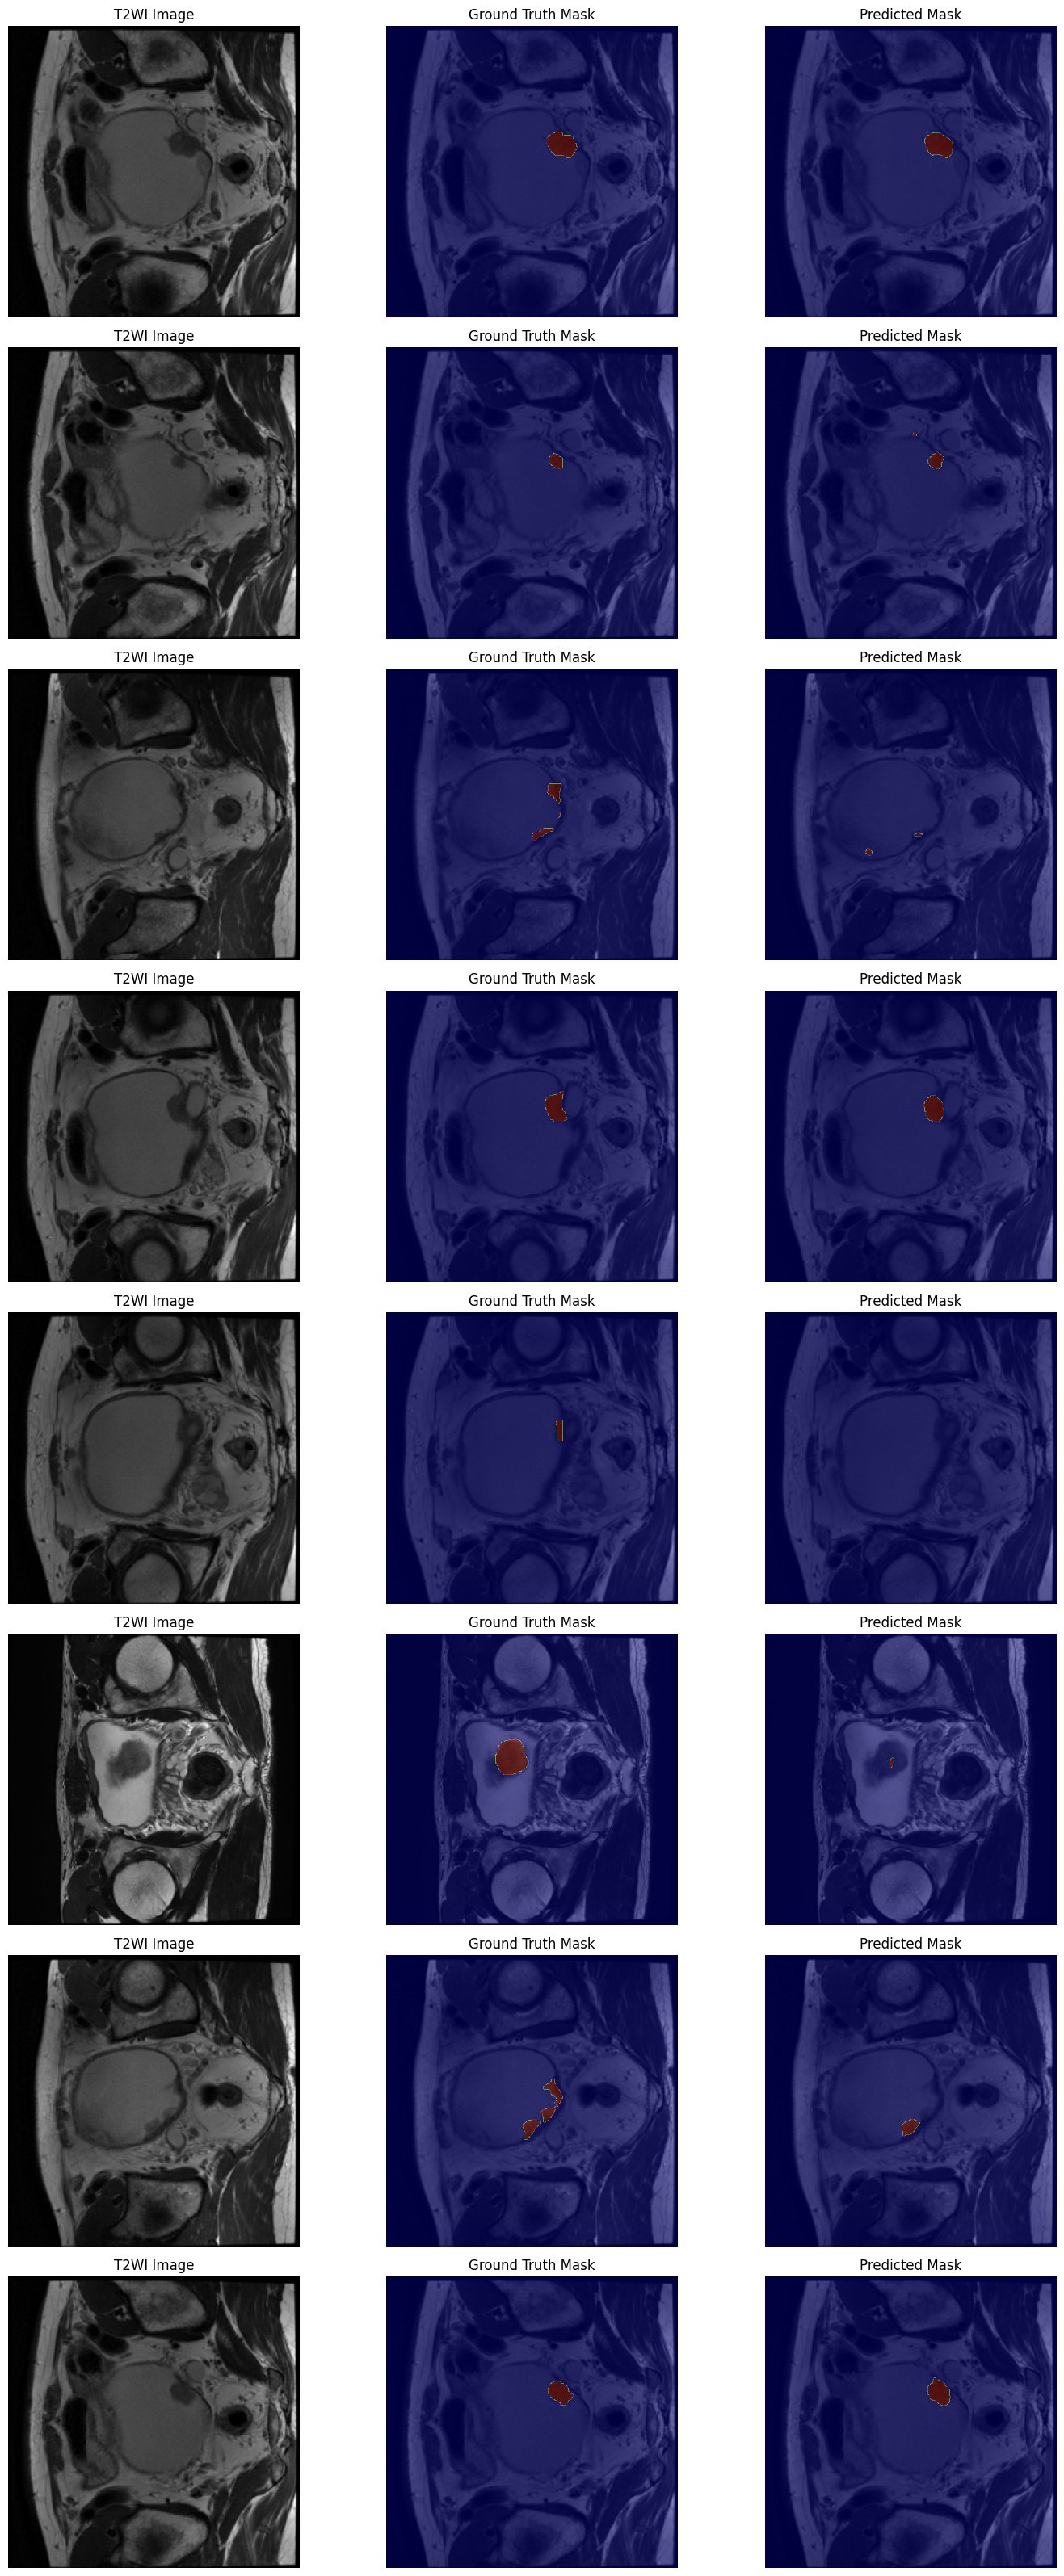

In [2]:
# !pip install segmentation-models-pytorch

import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define paths to your dataset
data_dir = "/kaggle/input/all-zendo-dataset/DATA/"  # Matches your dataset path
t2wi_dir = os.path.join(data_dir, "T2WI")
annotation_dir = os.path.join(data_dir, "Annotation")

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their annotations
image_mask_pairs = []
# First, collect all T2WI files
t2wi_files_dict = {}
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    if t2wi_files:  # Ensure there's at least one .nii file
        t2wi_path = os.path.join(subfolder_path, t2wi_files[0])  # Take the first .nii file
        t2wi_id = t2wi_subfolder.split(".")[0]  # e.g., "001"
        t2wi_files_dict[t2wi_id] = t2wi_path

# Now, collect annotation files (handle both direct .nii files and subfolders)
for item in os.listdir(annotation_dir):
    item_path = os.path.join(annotation_dir, item)
    if os.path.isdir(item_path):  # Case 1: Subfolder like "001.nii"
        ann_files = [f for f in os.listdir(item_path) if f.endswith(".nii")]
        if ann_files:
            ann_path = os.path.join(item_path, ann_files[0])
            ann_id = item.split(".")[0]  # e.g., "001"
            if ann_id in t2wi_files_dict:  # Match with T2WI
                image_mask_pairs.append((t2wi_files_dict[ann_id], ann_path))
    elif item.endswith(".nii"):  # Case 2: Direct .nii file
        ann_id = item.split(".")[0]  # e.g., "062YUANHEQ" -> need to extract the ID part
        # Adjust this based on your naming convention
        # Assuming the ID is the first 3 characters (e.g., "062" for "062YUANHEQ")
        possible_id = ann_id[:3] if len(ann_id) >= 3 else ann_id
        if possible_id in t2wi_files_dict:
            ann_path = item_path
            image_mask_pairs.append((t2wi_files_dict[possible_id], ann_path))

# Print the pairs to verify
print("Paired T2WI-Annotation files:", len(image_mask_pairs))
for t2wi_path, ann_path in image_mask_pairs[:5]:  # Show first 5 pairs
    print(f"T2WI: {t2wi_path}, Annotation: {ann_path}")

# Define resize transform
resize = transforms.Resize((256, 256))

# Custom Dataset class
class BladderTumorDataset(Dataset):
    def __init__(self, image_mask_pairs):
        self.image_mask_pairs = image_mask_pairs
        self.slices = []
        for idx, (img_path, mask_path) in enumerate(self.image_mask_pairs):
            try:
                img = load_nifti(img_path)
                mask = load_nifti(mask_path)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                mask = (mask > 0).astype(np.uint8)
                for z in range(mask.shape[2]):
                    if mask[:, :, z].sum() > 0:
                        self.slices.append((idx, z, img, mask))
            except Exception as e:
                print(f"Error loading pair {img_path} and {mask_path}: {e}")

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, mask = self.slices[idx]
        img_slice = img[:, :, z]
        mask_slice = mask[:, :, z]
        img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
        mask_slice = torch.LongTensor(mask_slice)
        img_slice = resize(img_slice)
        mask_slice = resize(mask_slice.unsqueeze(0)).squeeze(0)
        return img_slice, mask_slice

    def get_pair_index(self, idx):
        return self.slices[idx][0]

# Create dataset
dataset = BladderTumorDataset(image_mask_pairs)

# Split at the pair level
pair_indices = list(range(len(image_mask_pairs)))
train_pair_indices, val_pair_indices = train_test_split(pair_indices, test_size=0.2, random_state=42)
train_indices, val_indices = [], []
for slice_idx in range(len(dataset)):
    pair_idx = dataset.get_pair_index(slice_idx)
    if pair_idx in train_pair_indices:
        train_indices.append(slice_idx)
    elif pair_idx in val_pair_indices:
        val_indices.append(slice_idx)

# Create data loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=8, sampler=val_sampler)

# Model setup and training
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import torch.optim as optim

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=0.001)

def dice_score(pred, target, smooth=1):
    pred = torch.argmax(pred, dim=1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Training loop with validation
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images_batch, masks_batch in train_loader:
        images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
        outputs = model(images_batch)
        loss = criterion(outputs, masks_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images_batch, masks_batch in val_loader:
            images_batch, masks_batch = images_batch.to(device), masks_batch.to(device)
            outputs = model(images_batch)
            loss = criterion(outputs, masks_batch)
            val_loss += loss.item()
            dice = dice_score(outputs, masks_batch)
            val_dice += dice.item()
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

# Visualize predictions on validation set
model.eval()
val_iter = iter(val_loader)
images, masks = next(val_iter)  # Get one batch from validation set
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1)  # Convert logits to class predictions

# Move to CPU for visualization
images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()

# Visualize the first 18 samples in the batch (or fewer if batch is smaller)
num_samples = min(18, len(images))
plt.figure(figsize=(15, 4 * num_samples))
for i in range(num_samples):
    # T2WI image
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title("T2WI Image")
    plt.axis("off")
    
    # Ground truth mask
    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(images[i, 0], cmap="gray")
    plt.imshow(masks[i], cmap="jet", alpha=0.5)
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Predicted mask
    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(images[i, 0], cmap="gray")
    plt.imshow(preds[i], cmap="jet", alpha=0.5)
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

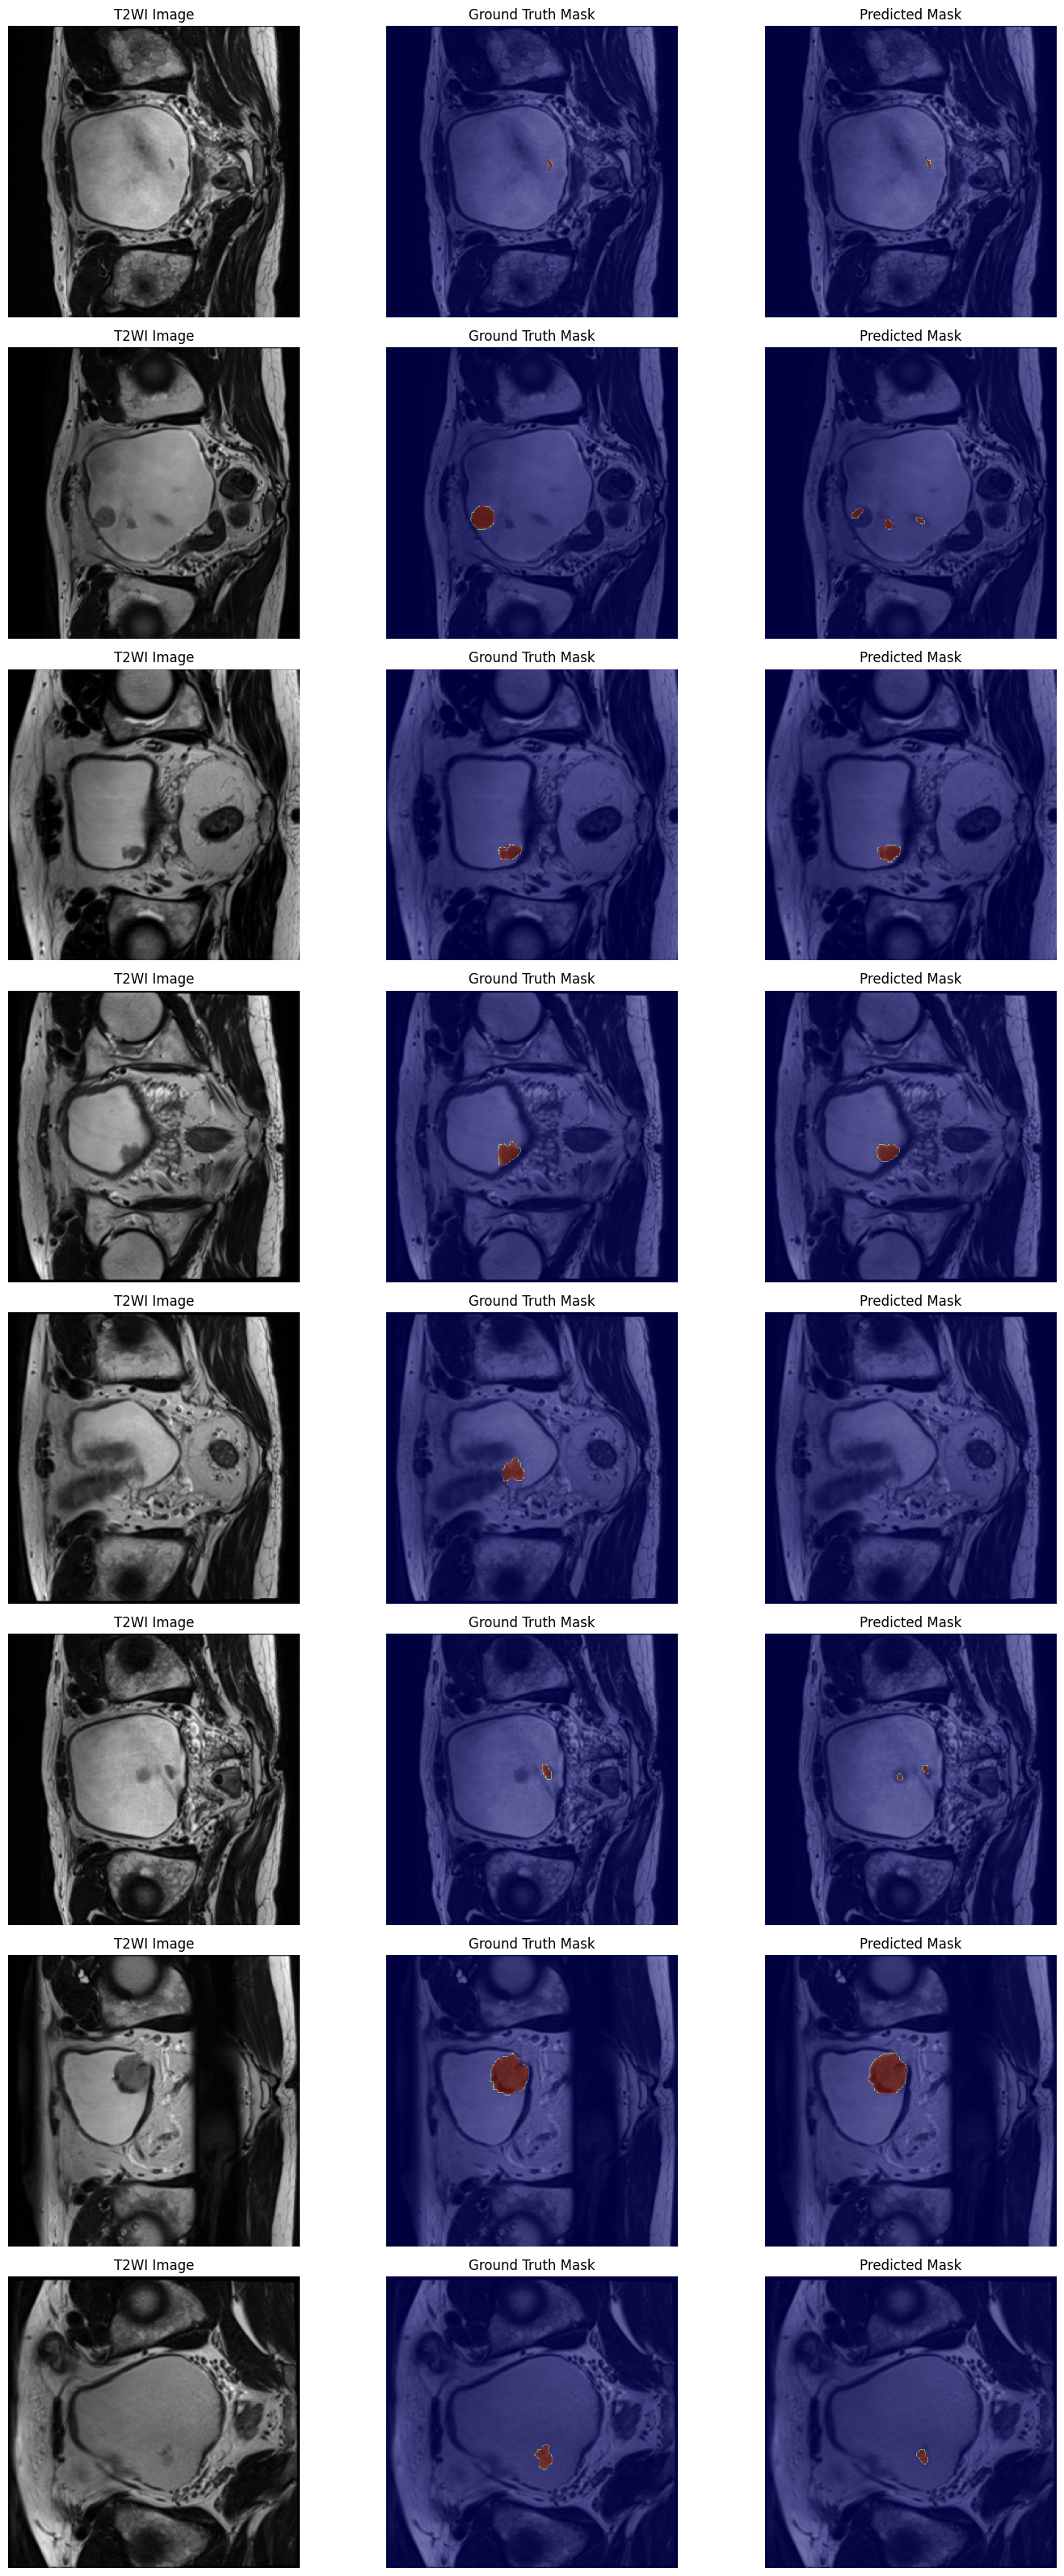

In [31]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os

# Define paths
new_file_path = "/kaggle/input/zendo-fed-bca/FedBCa/Center2/T2WI/01.nii/001 ZHENG CHENG.nii"  # Adjust this path to your new file
# model_path = "bladder_tumor_segmentation_model.pth"  # Path to your saved model weights

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Load and preprocess the new T2WI file
new_image = load_nifti(new_file_path)
new_image = (new_image - new_image.min()) / (new_image.max() - new_image.min() + 1e-8)  # Normalize to [0, 1]

# Define a dataset class for the new file (without annotations)
class TestDataset(Dataset):
    def __init__(self, image, resize_transform):
        self.image = image
        self.resize = resize_transform
        self.slices = []
        # Collect all slices (we'll predict on all slices since we don't have annotations)
        for z in range(image.shape[2]):
            self.slices.append(z)

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        z = self.slices[idx]
        img_slice = self.image[:, :, z]
        img_slice = torch.FloatTensor(img_slice).unsqueeze(0)  # Shape: [1, H, W]
        img_slice = self.resize(img_slice)  # Resize to 256x256
        return img_slice, z  # Return the slice and its z-index

# Define resize transform
resize = transforms.Resize((256, 256))

# Create test dataset and dataloader
test_dataset = TestDataset(new_image, resize)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the trained model
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,  # No pretrained weights since we're loading our own
    in_channels=1,
    classes=2,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load(model_path))
model.eval()

# Make predictions on the new file
predicted_masks = []
slice_indices = []
with torch.no_grad():
    for images_batch, z_indices in test_loader:
        images_batch = images_batch.to(device)
        outputs = model(images_batch)
        preds = torch.argmax(outputs, dim=1)  # Convert logits to class predictions
        predicted_masks.append(preds.cpu())
        slice_indices.extend(z_indices.tolist())

# Concatenate all predicted masks
predicted_masks = torch.cat(predicted_masks, dim=0)  # Shape: [num_slices, 256, 256]

# Visualize predictions for slices with predicted tumors
tumor_slices = [i for i, idx in enumerate(slice_indices) if predicted_masks[i].sum() > 0]
num_samples = min(4, len(tumor_slices))  # Visualize up to 4 slices with predicted tumors

if num_samples == 0:
    print("No tumors detected in the new file. Showing a few slices anyway.")
    tumor_slices = [len(slice_indices) // 4, len(slice_indices) // 2, 3 * len(slice_indices) // 4]
    num_samples = 3

plt.figure(figsize=(10, 4 * num_samples))
for i in range(num_samples):
    slice_idx = tumor_slices[i]
    z = slice_indices[slice_idx]
    
    # T2WI image
    plt.subplot(num_samples, 2, 2 * i + 1)
    img_slice = test_dataset.image[:, :, z]
    img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
    img_slice = resize(img_slice).squeeze(0).numpy()
    plt.imshow(img_slice, cmap="gray")
    plt.title(f"T2WI Slice {z}")
    plt.axis("off")
    
    # Predicted mask
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(img_slice, cmap="gray")
    plt.imshow(predicted_masks[slice_idx], cmap="jet", alpha=0.5)
    plt.title(f"Predicted Tumor Mask - Slice {z}")
    plt.axis("off")

plt.tight_layout()
plt.show()

NameError: name 'model_path' is not defined

# Classification 

CSV Columns: Index(['label', 'image_name', 'mask_name', 'Age (years)', 'Gender',
       'Pathological T stage', 'Pathological grade',
       'Type of patient's tumor number'],
      dtype='object')
First few rows of CSV:
   label  image_name      mask_name  Age (years) Gender Pathological T stage  \
0      0  c1_001.nii  c1_001.nii.gz           67   Male                   Ta   
1      0  c1_002.nii  c1_002.nii.gz           58   Male                   Ta   
2      0  c1_003.nii  c1_003.nii.gz           75   Male                   Ta   
3      0  c1_004.nii  c1_004.nii.gz           77   Male                   Ta   
4      1  c1_005.nii  c1_005.nii.gz           67   Male                   T2   

  Pathological grade Type of patient's tumor number  
0                Low                         Single  
1                Low                         Single  
2                Low                         Single  
3               High                         Single  
4               High        

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.5MB/s]


Epoch 1/100, Train Loss: 0.6660, Train Acc: 0.5511, Val Loss: 0.5516, Val Acc: 0.7727
Epoch 2/100, Train Loss: 0.6843, Train Acc: 0.6023, Val Loss: 0.5630, Val Acc: 0.7727
Epoch 3/100, Train Loss: 0.6599, Train Acc: 0.5795, Val Loss: 0.6737, Val Acc: 0.7727
Epoch 4/100, Train Loss: 0.6604, Train Acc: 0.6136, Val Loss: 0.7558, Val Acc: 0.2273
Epoch 5/100, Train Loss: 0.6557, Train Acc: 0.6023, Val Loss: 0.5713, Val Acc: 0.7727
Epoch 6/100, Train Loss: 0.6832, Train Acc: 0.5966, Val Loss: 0.6840, Val Acc: 0.7727
Epoch 7/100, Train Loss: 0.6144, Train Acc: 0.6534, Val Loss: 0.4332, Val Acc: 0.7727
Epoch 8/100, Train Loss: 0.6052, Train Acc: 0.6307, Val Loss: 0.6763, Val Acc: 0.7727
Epoch 9/100, Train Loss: 0.6338, Train Acc: 0.6420, Val Loss: 0.6449, Val Acc: 0.7727
Epoch 10/100, Train Loss: 0.6491, Train Acc: 0.6136, Val Loss: 0.6068, Val Acc: 0.7727
Epoch 11/100, Train Loss: 0.6346, Train Acc: 0.6193, Val Loss: 0.5395, Val Acc: 0.7727
Epoch 12/100, Train Loss: 0.6395, Train Acc: 0.6477,

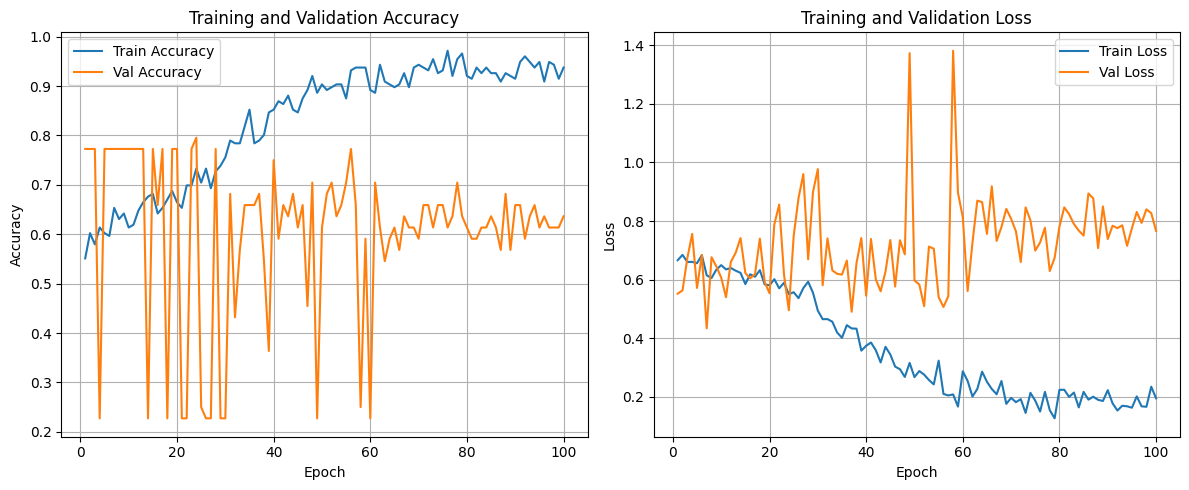

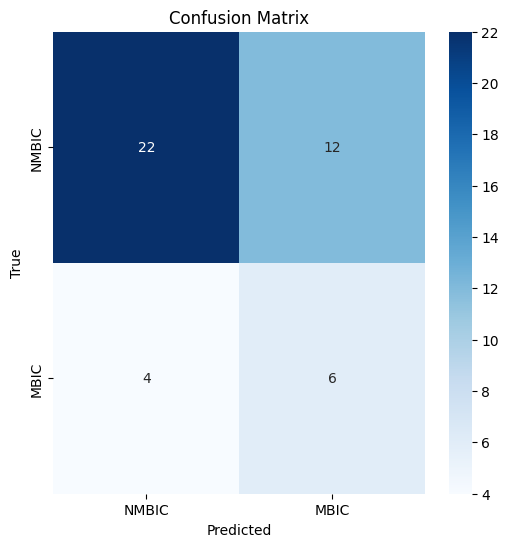

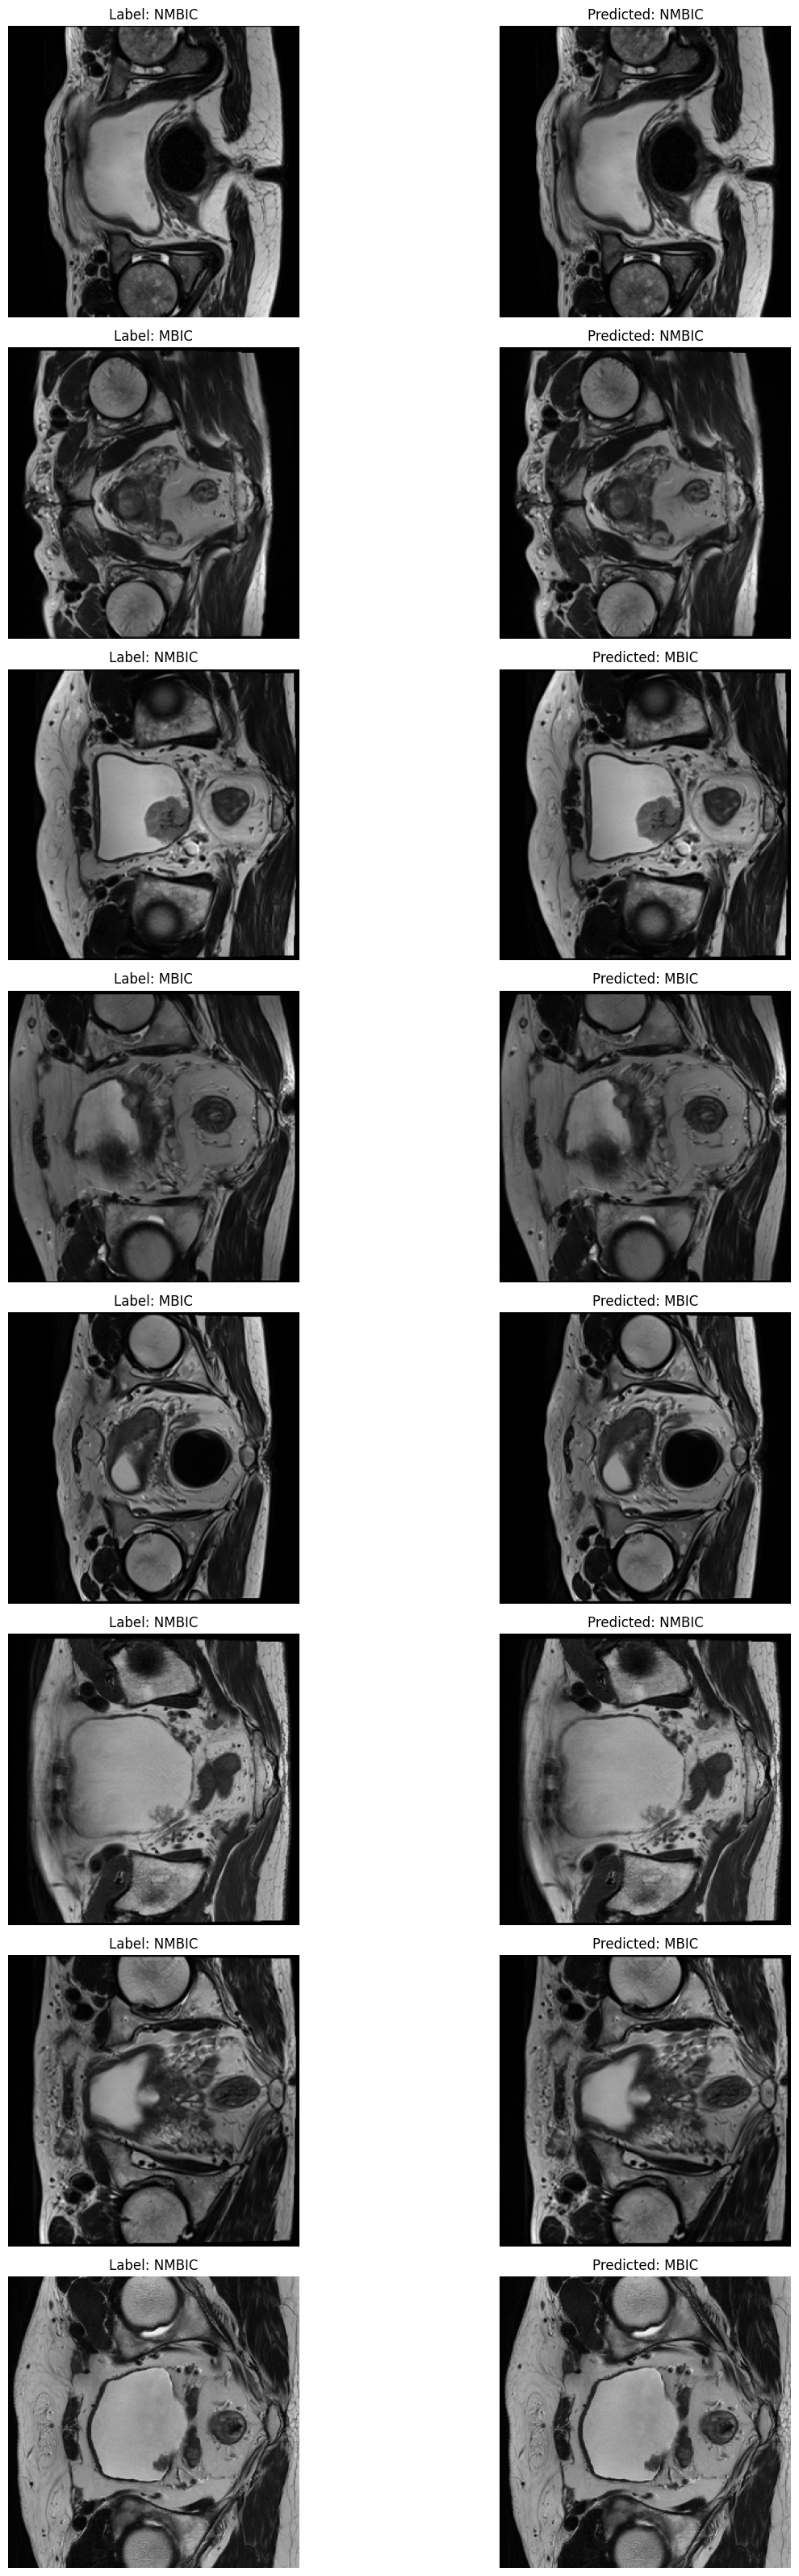

In [11]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define paths to your dataset
data_dir = "/kaggle/input/all-zendo-dataset/DATA/"
t2wi_dir = os.path.join(data_dir, "T2WI")
csv_path = "/kaggle/input/all-zendo-dataset/DATA/all_centers_combined.csv"

# Load the CSV file
df = pd.read_csv(csv_path)
df['image_name'] = df['image_name'].str.replace('.nii.gz', '.nii')
print("CSV Columns:", df.columns)
print("First few rows of CSV:")
print(df.head())

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their labels from the CSV
image_label_pairs = []
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    if t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_files[0])
        t2wi_id = t2wi_subfolder.split(".")[0]  # e.g., "c1_001"
        label_row = df[df['image_name'].str.replace('.nii', '') == t2wi_id]
        if not label_row.empty:
            label = label_row['label'].iloc[0]  # 0 for NMBIC, 1 for MBIC
            image_label_pairs.append((t2wi_path, label))
        else:
            print(f"No label found for T2WI ID {t2wi_id}")

# Print the pairs to verify
print("Paired T2WI-Label pairs:", len(image_label_pairs))
for t2wi_path, label in image_label_pairs[:5]:
    print(f"T2WI: {t2wi_path}, Label: {label}")

# Define data augmentation and transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
])

# Custom Dataset class for classification
class BladderCancerDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        self.image_label_pairs = image_label_pairs
        self.transform = transform
        self.slices = []
        for idx, (img_path, label) in enumerate(self.image_label_pairs):
            try:
                img = load_nifti(img_path)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                middle_slice = img.shape[2] // 2
                self.slices.append((idx, middle_slice, img, label))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, label = self.slices[idx]
        img_slice = img[:, :, z]  # Shape: [H, W]
        if self.transform:
            augmented = self.transform(image=img_slice)
            img_slice = augmented['image']  # Shape: [C, H, W], C=1
        else:
            img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
        label = torch.LongTensor([label])
        return img_slice, label

    def get_pair_index(self, idx):
        return self.slices[idx][0]

# Create datasets with transforms
train_dataset = BladderCancerDataset(image_label_pairs, transform=train_transform)
val_dataset = BladderCancerDataset(image_label_pairs, transform=val_transform)

# Split at the pair level
pair_indices = list(range(len(image_label_pairs)))
train_pair_indices, val_pair_indices = train_test_split(pair_indices, test_size=0.2, random_state=42)
train_indices, val_indices = [], []
for slice_idx in range(len(train_dataset)):
    pair_idx = train_dataset.get_pair_index(slice_idx)
    if pair_idx in train_pair_indices:
        train_indices.append(slice_idx)
    elif pair_idx in val_pair_indices:
        val_indices.append(slice_idx)

# Create data loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=8, sampler=val_sampler)

# Use a pretrained ResNet50 model
model = models.resnet50(pretrained=True)
# Modify the first conv layer for grayscale input (1 channel)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Modify the final fully connected layer for binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 classes: NMBIC (0) and MBIC (1)
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate for pretrained model
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop with validation
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images_batch, labels_batch in train_loader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device).squeeze(1)
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels_batch.size(0)
        train_correct += (predicted == labels_batch).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device).squeeze(1)
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted == labels_batch).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    scheduler.step()

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NMBIC', 'MBIC'], yticklabels=['NMBIC', 'MBIC'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize predictions on validation set
model.eval()
val_iter = iter(val_loader)
images, labels = next(val_iter)
images, labels = images.to(device), labels.to(device).squeeze(1)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Move to CPU for visualization
images, labels, preds = images.cpu(), labels.cpu(), preds.cpu()

# Visualize the first 8 samples in the batch
num_samples = min(8, len(images))
plt.figure(figsize=(15, 4 * num_samples))
for i in range(num_samples):
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title(f"Label: {'MBIC' if labels[i] == 1 else 'NMBIC'}")
    plt.axis("off")
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title(f"Predicted: {'MBIC' if preds[i] == 1 else 'NMBIC'}")
    plt.axis("off")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


CSV Columns: Index(['label', 'image_name', 'mask_name', 'Age (years)', 'Gender',
       'Pathological T stage', 'Pathological grade',
       'Type of patient's tumor number'],
      dtype='object')
First few rows of CSV:
   label  image_name      mask_name  Age (years) Gender Pathological T stage  \
0      0  c1_001.nii  c1_001.nii.gz           67   Male                   Ta   
1      0  c1_002.nii  c1_002.nii.gz           58   Male                   Ta   
2      0  c1_003.nii  c1_003.nii.gz           75   Male                   Ta   
3      0  c1_004.nii  c1_004.nii.gz           77   Male                   Ta   
4      1  c1_005.nii  c1_005.nii.gz           67   Male                   T2   

  Pathological grade Type of patient's tumor number  
0                Low                         Single  
1                Low                         Single  
2                Low                         Single  
3               High                         Single  
4               High        

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100, Train Loss: 0.6894, Train Acc: 0.5511, Val Loss: 0.6385, Val Acc: 0.7727
Epoch 2/100, Train Loss: 0.6609, Train Acc: 0.5568, Val Loss: 0.7230, Val Acc: 0.2273
Epoch 3/100, Train Loss: 0.6331, Train Acc: 0.6193, Val Loss: 0.6733, Val Acc: 0.7727
Epoch 4/100, Train Loss: 0.6187, Train Acc: 0.6989, Val Loss: 0.7108, Val Acc: 0.2273
Epoch 5/100, Train Loss: 0.6301, Train Acc: 0.5966, Val Loss: 0.5617, Val Acc: 0.7500
Epoch 6/100, Train Loss: 0.6094, Train Acc: 0.6648, Val Loss: 0.7472, Val Acc: 0.3409
Epoch 7/100, Train Loss: 0.6192, Train Acc: 0.6705, Val Loss: 0.7214, Val Acc: 0.2273
Epoch 8/100, Train Loss: 0.6639, Train Acc: 0.6534, Val Loss: 0.7336, Val Acc: 0.2273
Epoch 9/100, Train Loss: 0.6001, Train Acc: 0.6477, Val Loss: 0.6880, Val Acc: 0.4545
Epoch 10/100, Train Loss: 0.5895, Train Acc: 0.6705, Val Loss: 0.8092, Val Acc: 0.7727
Epoch 11/100, Train Loss: 0.6104, Train Acc: 0.6989, Val Loss: 0.5110, Val Acc: 0.7727
Epoch 12/100, Train Loss: 0.5818, Train Acc: 0.7216,

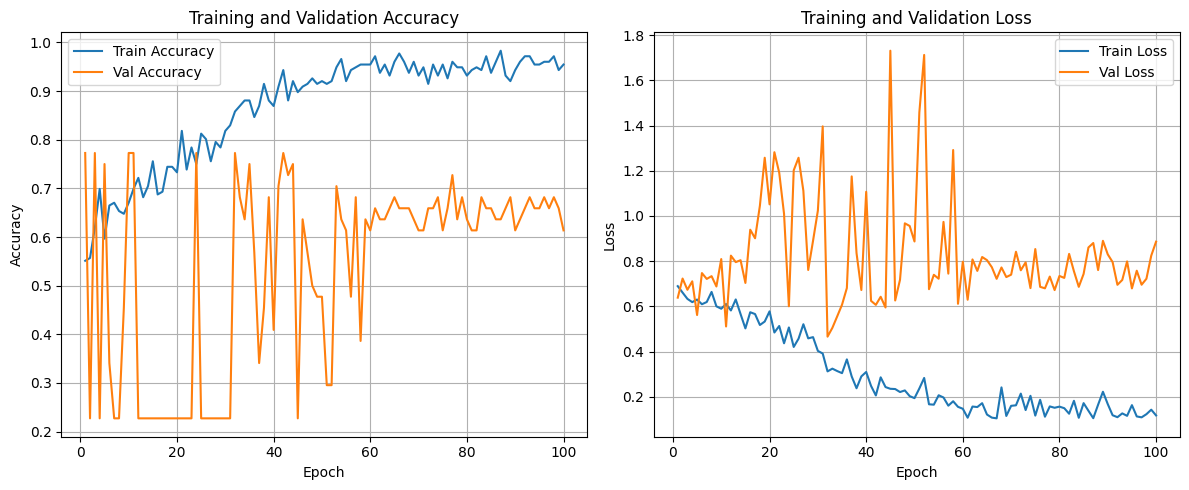

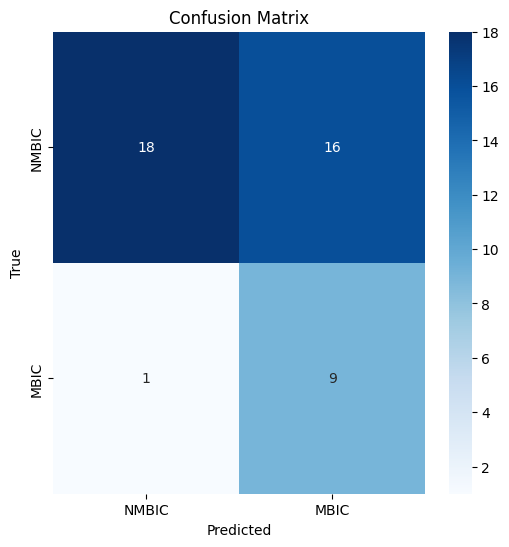

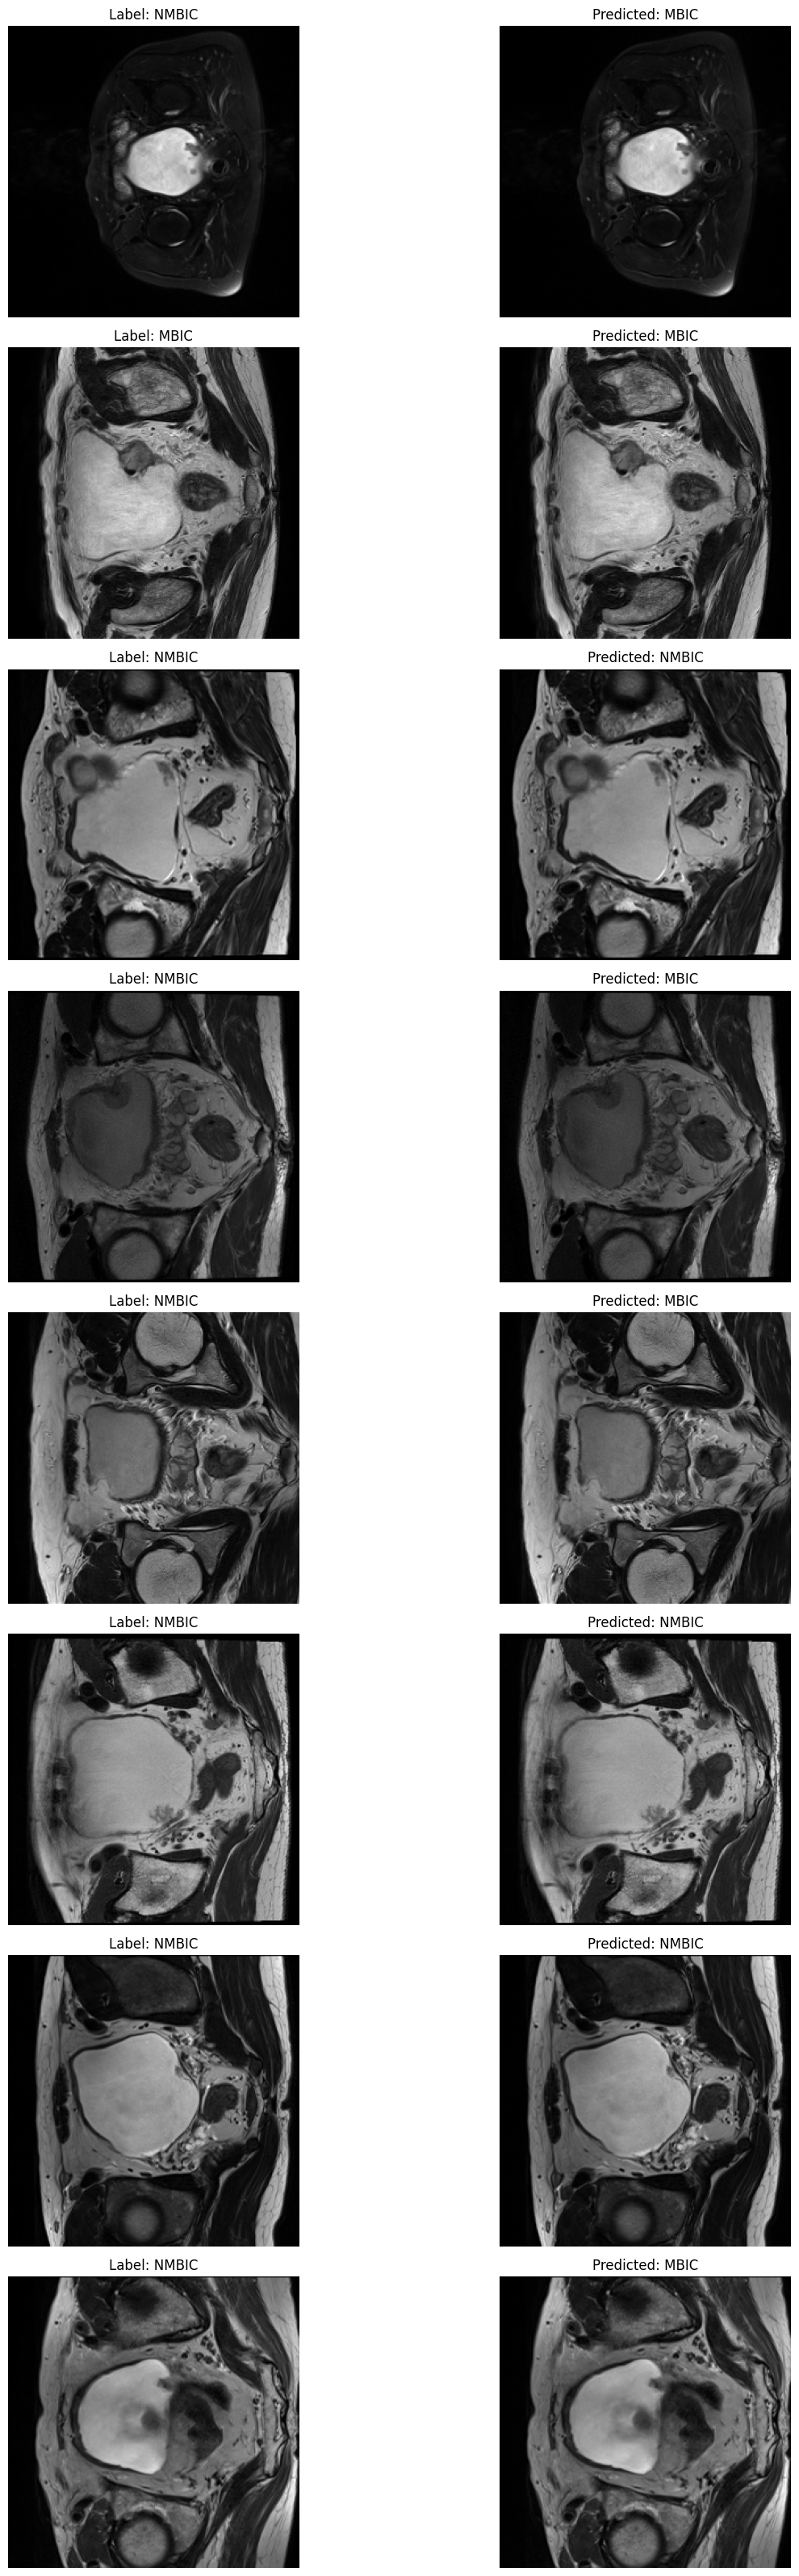

In [1]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define paths to your dataset
data_dir = "/kaggle/input/all-zendo-dataset/DATA/"
t2wi_dir = os.path.join(data_dir, "T2WI")
csv_path = "/kaggle/input/all-zendo-dataset/DATA/all_centers_combined.csv"

# Load the CSV file
df = pd.read_csv(csv_path)
df['image_name'] = df['image_name'].str.replace('.nii.gz', '.nii')
print("CSV Columns:", df.columns)
print("First few rows of CSV:")
print(df.head())

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their labels from the CSV
image_label_pairs = []
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    if t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_files[0])
        t2wi_id = t2wi_subfolder.split(".")[0]
        label_row = df[df['image_name'].str.replace('.nii', '') == t2wi_id]
        if not label_row.empty:
            label = label_row['label'].iloc[0]
            image_label_pairs.append((t2wi_path, label))
        else:
            print(f"No label found for T2WI ID {t2wi_id}")

print("Paired T2WI-Label pairs:", len(image_label_pairs))
for t2wi_path, label in image_label_pairs[:5]:
    print(f"T2WI: {t2wi_path}, Label: {label}")

# Define data augmentation and transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
])

# Custom Dataset class for classification
class BladderCancerDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        self.image_label_pairs = image_label_pairs
        self.transform = transform
        self.slices = []
        for idx, (img_path, label) in enumerate(self.image_label_pairs):
            try:
                img = load_nifti(img_path)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                middle_slice = img.shape[2] // 2
                self.slices.append((idx, middle_slice, img, label))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, label = self.slices[idx]
        img_slice = img[:, :, z]
        if self.transform:
            augmented = self.transform(image=img_slice)
            img_slice = augmented['image']
        else:
            img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
        label = torch.LongTensor([label])
        return img_slice, label

    def get_pair_index(self, idx):
        return self.slices[idx][0]

# Create datasets with transforms
train_dataset = BladderCancerDataset(image_label_pairs, transform=train_transform)
val_dataset = BladderCancerDataset(image_label_pairs, transform=val_transform)

# Split at the pair level
pair_indices = list(range(len(image_label_pairs)))
train_pair_indices, val_pair_indices = train_test_split(pair_indices, test_size=0.2, random_state=42)
train_indices, val_indices = [], []
for slice_idx in range(len(train_dataset)):
    pair_idx = train_dataset.get_pair_index(slice_idx)
    if pair_idx in train_pair_indices:
        train_indices.append(slice_idx)
    elif pair_idx in val_pair_indices:
        val_indices.append(slice_idx)

# Create data loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=8, sampler=val_sampler)

# Use a pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop with validation
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images_batch, labels_batch in train_loader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device).squeeze(1)
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels_batch.size(0)
        train_correct += (predicted == labels_batch).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device).squeeze(1)
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted == labels_batch).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    scheduler.step()

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NMBIC', 'MBIC'], yticklabels=['NMBIC', 'MBIC'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize predictions on validation set
model.eval()
val_iter = iter(val_loader)
images, labels = next(val_iter)
images, labels = images.to(device), labels.to(device).squeeze(1)
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
images, labels, preds = images.cpu(), labels.cpu(), preds.cpu()
num_samples = min(8, len(images))
plt.figure(figsize=(15, 4 * num_samples))
for i in range(num_samples):
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title(f"Label: {'MBIC' if labels[i] == 1 else 'NMBIC'}")
    plt.axis("off")
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title(f"Predicted: {'MBIC' if preds[i] == 1 else 'NMBIC'}")
    plt.axis("off")
plt.tight_layout()
plt.show()

CSV Columns: Index(['label', 'image_name', 'mask_name', 'Age (years)', 'Gender',
       'Pathological T stage', 'Pathological grade',
       'Type of patient's tumor number'],
      dtype='object')
First few rows of CSV:
   label  image_name      mask_name  Age (years) Gender Pathological T stage  \
0      0  c1_001.nii  c1_001.nii.gz           67   Male                   Ta   
1      0  c1_002.nii  c1_002.nii.gz           58   Male                   Ta   
2      0  c1_003.nii  c1_003.nii.gz           75   Male                   Ta   
3      0  c1_004.nii  c1_004.nii.gz           77   Male                   Ta   
4      1  c1_005.nii  c1_005.nii.gz           67   Male                   T2   

  Pathological grade Type of patient's tumor number  
0                Low                         Single  
1                Low                         Single  
2                Low                         Single  
3               High                         Single  
4               High        

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100, Train Loss: 0.6669, Train Acc: 0.5852, Val Loss: 0.7405, Val Acc: 0.2273
Epoch 2/100, Train Loss: 0.6739, Train Acc: 0.5568, Val Loss: 0.7222, Val Acc: 0.2273
Epoch 3/100, Train Loss: 0.6466, Train Acc: 0.6250, Val Loss: 0.7898, Val Acc: 0.2273
Epoch 4/100, Train Loss: 0.6372, Train Acc: 0.6023, Val Loss: 0.8395, Val Acc: 0.2273
Epoch 5/100, Train Loss: 0.6502, Train Acc: 0.6477, Val Loss: 0.8165, Val Acc: 0.2273
Epoch 6/100, Train Loss: 0.6198, Train Acc: 0.6364, Val Loss: 0.9692, Val Acc: 0.2273
Epoch 7/100, Train Loss: 0.6543, Train Acc: 0.6193, Val Loss: 0.9233, Val Acc: 0.2273
Epoch 8/100, Train Loss: 0.6182, Train Acc: 0.6534, Val Loss: 0.8479, Val Acc: 0.2273
Epoch 9/100, Train Loss: 0.6146, Train Acc: 0.6591, Val Loss: 0.5514, Val Acc: 0.6591
Epoch 10/100, Train Loss: 0.5948, Train Acc: 0.6648, Val Loss: 0.5755, Val Acc: 0.6591
Epoch 11/100, Train Loss: 0.5727, Train Acc: 0.6989, Val Loss: 0.5947, Val Acc: 0.6364
Epoch 12/100, Train Loss: 0.5489, Train Acc: 0.7159,

/tmp/ipykernel_31/2609308086.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


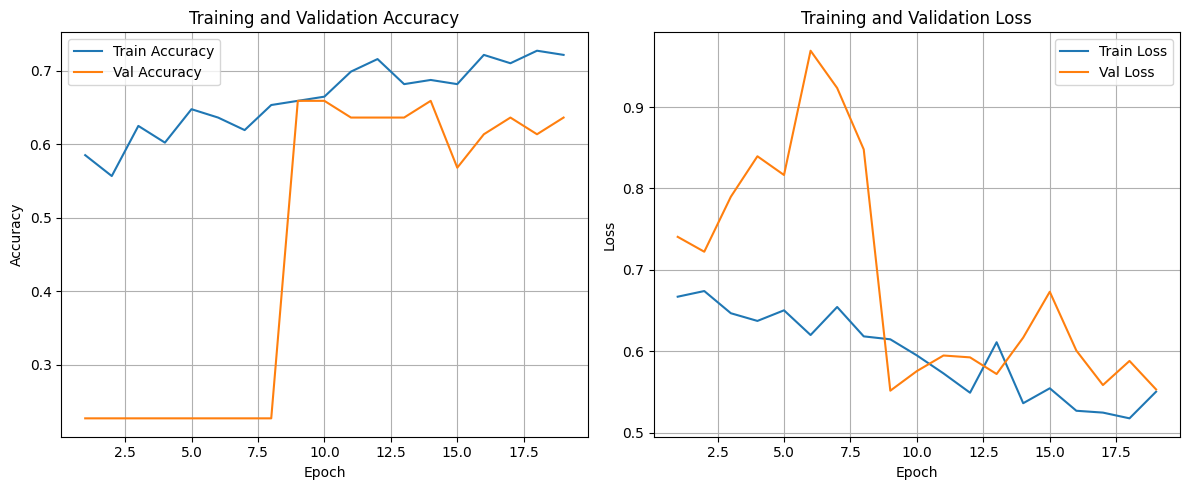

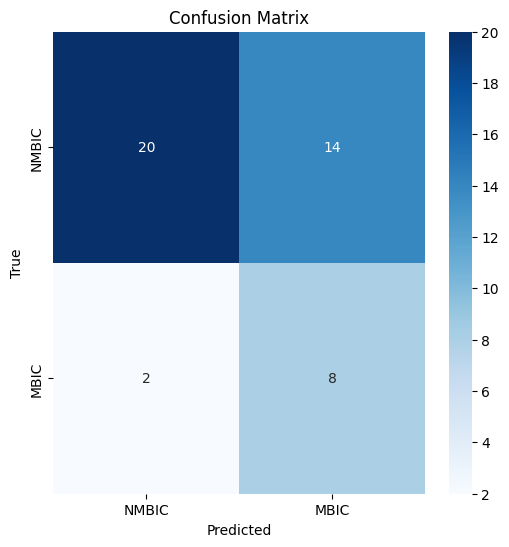

In [3]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define paths to your dataset
data_dir = "/kaggle/input/all-zendo-dataset/DATA/"
t2wi_dir = os.path.join(data_dir, "T2WI")
csv_path = "/kaggle/input/all-zendo-dataset/DATA/all_centers_combined.csv"

# Load the CSV file
df = pd.read_csv(csv_path)
df['image_name'] = df['image_name'].str.replace('.nii.gz', '.nii')
print("CSV Columns:", df.columns)
print("First few rows of CSV:")
print(df.head())

# Function to load a NIfTI file
def load_nifti(file_path):
    nifti = nib.load(file_path)
    return nifti.get_fdata()

# Pair T2WI images with their labels from the CSV
image_label_pairs = []
for t2wi_subfolder in os.listdir(t2wi_dir):
    subfolder_path = os.path.join(t2wi_dir, t2wi_subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    t2wi_files = [f for f in os.listdir(subfolder_path) if f.endswith(".nii")]
    if t2wi_files:
        t2wi_path = os.path.join(subfolder_path, t2wi_files[0])
        t2wi_id = t2wi_subfolder.split(".")[0]
        label_row = df[df['image_name'].str.replace('.nii', '') == t2wi_id]
        if not label_row.empty:
            label = label_row['label'].iloc[0]
            image_label_pairs.append((t2wi_path, label))
        else:
            print(f"No label found for T2WI ID {t2wi_id}")

print("Paired T2WI-Label pairs:", len(image_label_pairs))
for t2wi_path, label in image_label_pairs[:5]:
    print(f"T2WI: {t2wi_path}, Label: {label}")

# Compute class weights to handle imbalance
labels = [pair[1] for pair in image_label_pairs]
nmbic_count = labels.count(0)
mbic_count = labels.count(1)
total = nmbic_count + mbic_count
class_weights = torch.tensor([total / (2 * nmbic_count), total / (2 * mbic_count)]).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Class Weights (NMBIC, MBIC): {class_weights}")

# Define data augmentation and transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
])

# Custom Dataset class for classification
class BladderCancerDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        self.image_label_pairs = image_label_pairs
        self.transform = transform
        self.slices = []
        for idx, (img_path, label) in enumerate(self.image_label_pairs):
            try:
                img = load_nifti(img_path)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                middle_slice = img.shape[2] // 2
                self.slices.append((idx, middle_slice, img, label))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        img_idx, z, img, label = self.slices[idx]
        img_slice = img[:, :, z]
        if self.transform:
            augmented = self.transform(image=img_slice)
            img_slice = augmented['image']
        else:
            img_slice = torch.FloatTensor(img_slice).unsqueeze(0)
        label = torch.LongTensor([label])
        return img_slice, label

    def get_pair_index(self, idx):
        return self.slices[idx][0]

# Create datasets with transforms
train_dataset = BladderCancerDataset(image_label_pairs, transform=train_transform)
val_dataset = BladderCancerDataset(image_label_pairs, transform=val_transform)

# Split at the pair level
pair_indices = list(range(len(image_label_pairs)))
train_pair_indices, val_pair_indices = train_test_split(pair_indices, test_size=0.2, random_state=42)
train_indices, val_indices = [], []
for slice_idx in range(len(train_dataset)):
    pair_idx = train_dataset.get_pair_index(slice_idx)
    if pair_idx in train_pair_indices:
        train_indices.append(slice_idx)
    elif pair_idx in val_pair_indices:
        val_indices.append(slice_idx)

# Create data loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=8, sampler=val_sampler)

# Use a pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(512, 2)
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss, optimizer, and scheduler with weight decay
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training loop with validation and early stopping
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images_batch, labels_batch in train_loader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device).squeeze(1)
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels_batch.size(0)
        train_correct += (predicted == labels_batch).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device).squeeze(1)
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted == labels_batch).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NMBIC', 'MBIC'], yticklabels=['NMBIC', 'MBIC'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize predictions on validation set
model.eval()
val_iter = iter(val_loader)
images, labels = next(val_iter)
images, labels = images.to(device), labels.to(device).squeeze(1)
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
images, labels, preds = images.cpu(), labels.cpu(), preds.cpu()

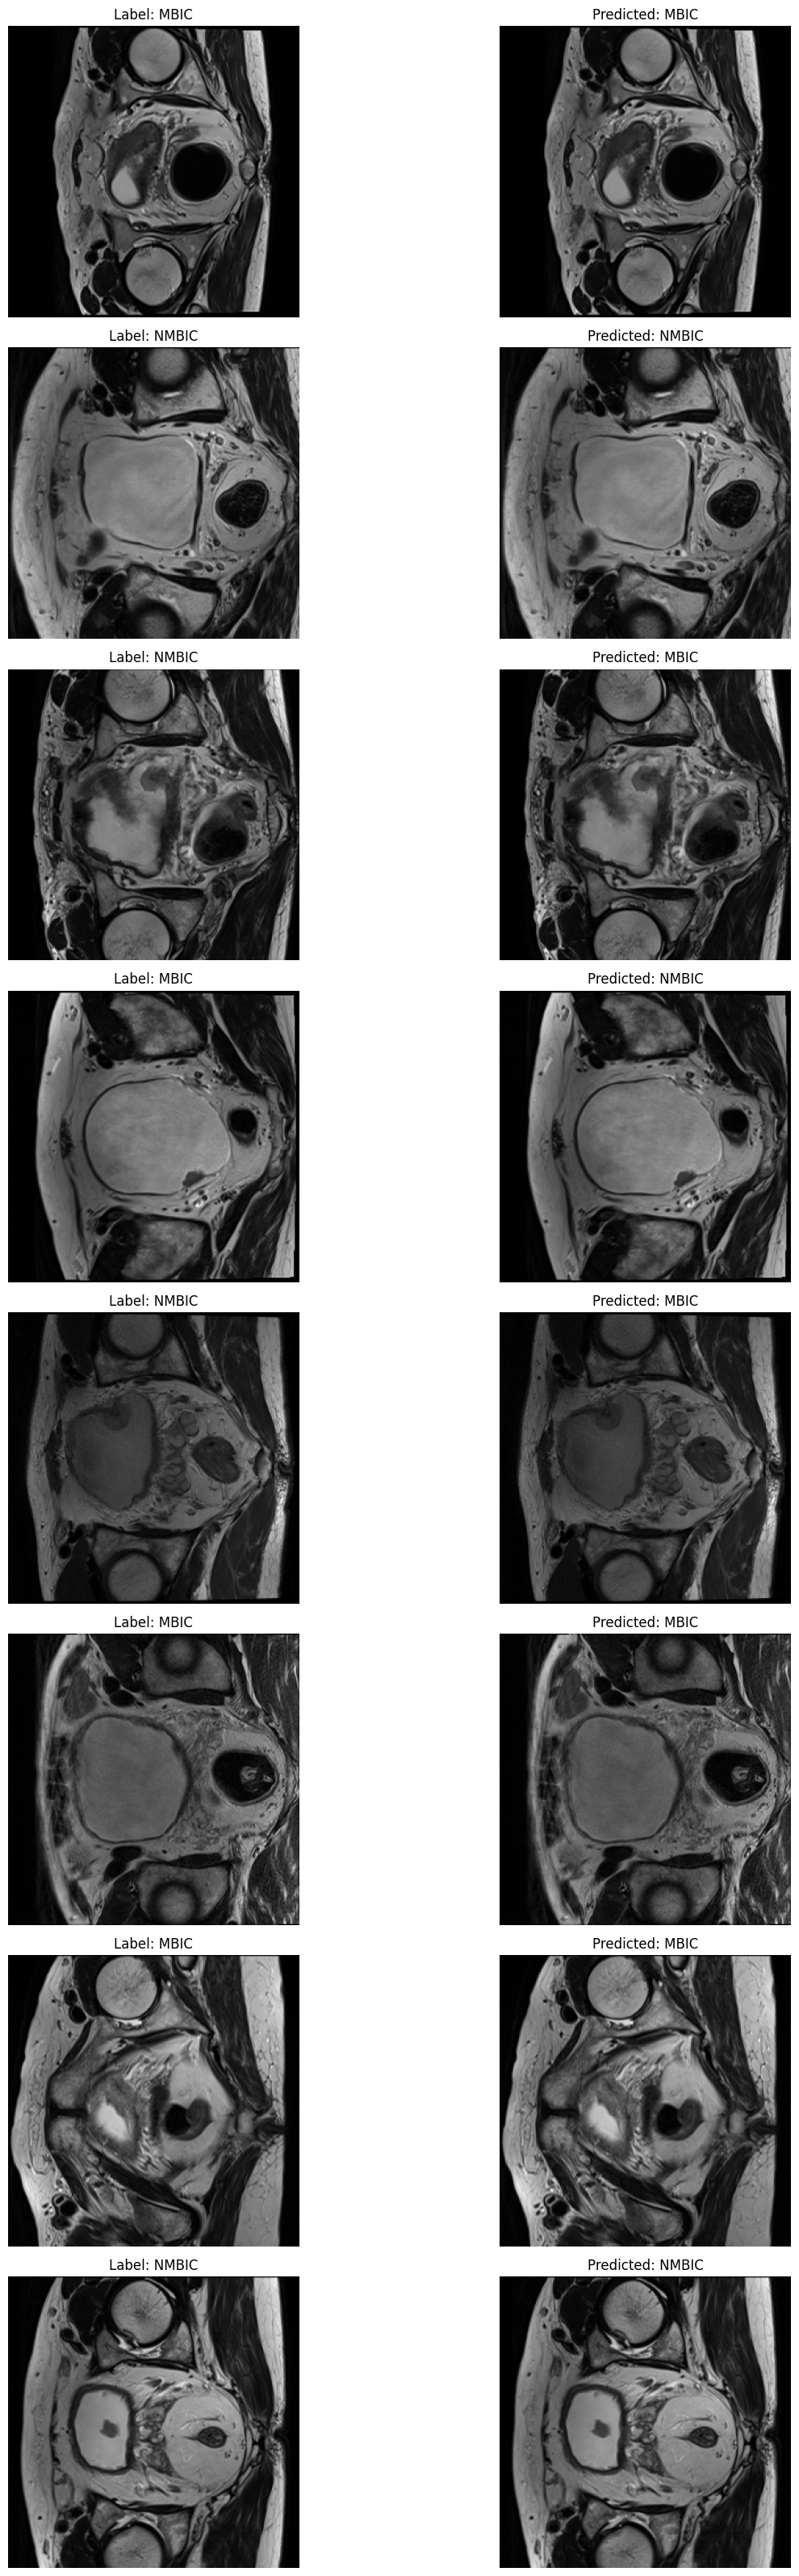

In [2]:
num_samples = min(15, len(images))
plt.figure(figsize=(15, 4 * num_samples))
for i in range(num_samples):
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title(f"Label: {'MBIC' if labels[i] == 1 else 'NMBIC'}")
    plt.axis("off")
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(images[i, 0], cmap="gray")
    plt.title(f"Predicted: {'MBIC' if preds[i] == 1 else 'NMBIC'}")
    plt.axis("off")
plt.tight_layout()
plt.show()